In [3]:
from astropy.table import Table
from astropy.io import fits
import astropy.units as U

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats
import scipy.optimize

In [4]:
! ls /pscratch/sd/e/edown/outputs

outdir_xirunpc_maglim_18_DA02		outdir_xirunpc_no_maglim_DA02_fullonly
outdir_xirunpc_maglim_18_sv3		outdir_xirunpc_sv3_magbins
outdir_xirunpc_no_maglim_da02_fullonly


In [5]:
N = Table.read('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/clustering/BGS_ANY_N_clustering.dat.fits')
S = Table.read('/global/cfs/cdirs/desi/survey/catalogs/edav1/sv3/LSScats/clustering/BGS_ANY_S_clustering.dat.fits')
data = Table(np.hstack((N,S))) #BGS ANY in N, S combined

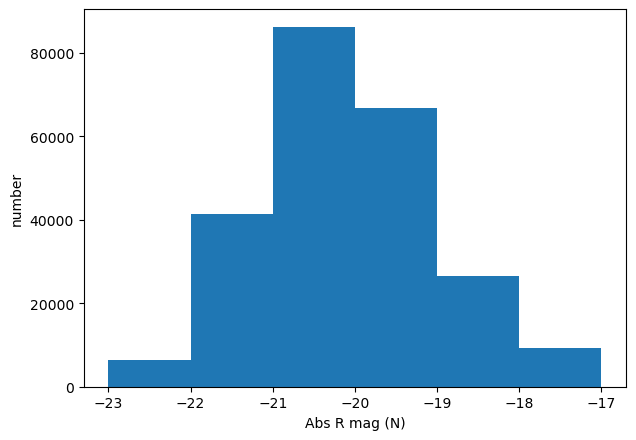

In [6]:
plt.figure(figsize=(7,5),dpi=100)
M_range = np.arange(-23,-16,1)
plt.hist(data['ABSMAG_R'], bins=M_range)
plt.xlabel('Abs R mag (N)')
plt.ylabel('number')

plt.show()

In [7]:
#columns rpmid | rpavg | corr(rp) | std(rp)
#          0       1        2         3
wp_17_18 = np.genfromtxt('/pscratch/sd/e/edown/outputs/outdir_xirunpc_sv3_magbins/17_18/rppi/wp_BGS_ANY_NScomb_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
wp_18_19 = np.genfromtxt('/pscratch/sd/e/edown/outputs/outdir_xirunpc_sv3_magbins/18_19/rppi/wp_BGS_ANY_NScomb_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
wp_19_20 = np.genfromtxt('/pscratch/sd/e/edown/outputs/outdir_xirunpc_sv3_magbins/19_20/rppi/wp_BGS_ANY_NScomb_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
wp_20_21 = np.genfromtxt('/pscratch/sd/e/edown/outputs/outdir_xirunpc_sv3_magbins/20_21/rppi/wp_BGS_ANY_NScomb_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
wp_21_22 = np.genfromtxt('/pscratch/sd/e/edown/outputs/outdir_xirunpc_sv3_magbins/21_22/rppi/wp_BGS_ANY_NScomb_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')
wp_22_23 = np.genfromtxt('/pscratch/sd/e/edown/outputs/outdir_xirunpc_sv3_magbins/22_23/rppi/wp_BGS_ANY_NScomb_0.1_0.5fullonly_default_log2_njack60_nran4_split20.txt')

In [50]:
def chi_squared(model_params, model, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, model_params))/y_error)**2)

from scipy.special import gamma

def power_law(r, param_vals):
    return (r*(r/param_vals[0])**-param_vals[1]*gamma(1/2)*gamma((param_vals[1]-1)/2))/(gamma(param_vals[1]/2)) #eq 4 zehavi+05

In [52]:
print(power_law(1,[10,2.04]))

335.26354227206633


In [18]:
def fit_to_power(initial_values, x, y, yerr, p=False):
    initial_values = np.array(initial_values)
    model_function = power_law    
    deg_freedom = x.size - initial_values.size
    fit_linear = scipy.optimize.minimize(chi_squared, initial_values, args=(model_function, x, y, yerr))

    r0_solution = fit_linear.x[0] #Parameter values
    g_solution = fit_linear.x[1]

    #Check chi-squared
    chisq_min = chi_squared([r0_solution, g_solution], model_function, x, y, yerr)
    chisq_reduced = chisq_min/deg_freedom
    P_value = scipy.stats.chi2.sf(chisq_min, deg_freedom)

    if p==True:
        print("DoF = {}".format(deg_freedom))
        print(fit_linear.success) #DId the minimisation complete successfully?
        print(fit_linear.message) #Additional termination output information
        print('minimised chi-squared = {}'.format(fit_linear.fun))
        print("chi^2_min = {}".format(chisq_min))
        print("reduced_chi^2 = {}".format(chisq_reduced))  
        print('P(chi^2_min, DoF) = {}'.format(P_value))
    print(r0_solution,g_solution)
    print('')
    return [r0_solution, g_solution]

In [45]:
def remove_nan(wp):
    xnans = np.argwhere(np.isnan(wp[:,0]))
    ynans = np.argwhere(np.isnan(wp[:,2]))
    yerrnans = np.argwhere(np.isnan(wp[:,3]))
    xynans = np.union1d(xnans, ynans)
    anynans = np.union1d(xynans, yerrnans)
    print(anynans)
    wp2 = np.delete(wp, anynans, axis=0)
    return wp2

wp_17_18_nonans = remove_nan(wp_17_18)
wp_18_19_nonans = remove_nan(wp_18_19)
wp_19_20_nonans = remove_nan(wp_19_20)
wp_20_21_nonans = remove_nan(wp_20_21)
wp_21_22_nonans = remove_nan(wp_21_22)
wp_22_23_nonans = remove_nan(wp_22_23)


[0 1 2 3 4]
[0 2]
[]
[0]
[0 1 2]
[0 1 2 3 4 5 6 7 8]


In [53]:
Z_power_17_18 = [2.83,1.94] #d
Z_power_18_19 = [3.77,1.89]
Z_power_19_20 = [4.74,1.85]
Z_power_20_21 = [4.96,1.86]
Z_power_21_22 = [6.27,1.86]
Z_power_22_23 = [10.00,2.04]

In [55]:
# index = np.argwhere(np.isnan(A)), A2 = np.delete(A, index)

power_17_18 = fit_to_power([2.8,1.5],x=wp_17_18_nonans[:,0], y=wp_17_18_nonans[:,2], yerr=wp_17_18_nonans[:,3])
power_18_19 = fit_to_power([3.5,1.5],x=wp_18_19_nonans[:,0], y=wp_18_19_nonans[:,2], yerr=wp_18_19_nonans[:,3])
power_19_20 = fit_to_power([4.5,1.5],x=wp_19_20_nonans[:,0], y=wp_19_20_nonans[:,2], yerr=wp_19_20_nonans[:,3])
power_20_21 = fit_to_power([4.5,1.5],x=wp_20_21_nonans[:,0], y=wp_20_21_nonans[:,2], yerr=wp_20_21_nonans[:,3])
power_21_22 = fit_to_power([6.0,1.5],x=wp_21_22_nonans[:,0], y=wp_21_22_nonans[:,2], yerr=wp_21_22_nonans[:,3])
power_22_23 = fit_to_power([9.0,2.04],x=wp_22_23_nonans[:,0], y=wp_22_23_nonans[:,2], yerr=wp_22_23_nonans[:,3])

3.5775655055670095 1.766138406973027

4.195124482360021 1.649596037421679

4.500698398617782 1.718519787189589

5.00654151550588 1.7476820728331834

5.95623480519895 1.8350502428963407

8.033014845744935 1.9776881662430095



In [56]:
wp_17_18_nonanlim = np.intersect1d(np.where(wp_17_18_nonans[:,0] > 0.1)[0],np.where(wp_17_18_nonans[:,0] < 40)[0])
wp_18_19_nonanlim = np.intersect1d(np.where(wp_18_19_nonans[:,0] > 0.1)[0],np.where(wp_18_19_nonans[:,0] < 40)[0])
wp_19_20_nonanlim = np.intersect1d(np.where(wp_19_20_nonans[:,0] > 0.1)[0],np.where(wp_19_20_nonans[:,0] < 40)[0])
wp_20_21_nonanlim = np.intersect1d(np.where(wp_20_21_nonans[:,0] > 0.1)[0],np.where(wp_20_21_nonans[:,0] < 40)[0])
wp_21_22_nonanlim = np.intersect1d(np.where(wp_21_22_nonans[:,0] > 0.1)[0],np.where(wp_21_22_nonans[:,0] < 40)[0])
wp_22_23_nonanlim = np.intersect1d(np.where(wp_22_23_nonans[:,0] > 0.1)[0],np.where(wp_22_23_nonans[:,0] < 40)[0])

power_17_18_lim = fit_to_power([2.5,1.5], x=wp_17_18_nonans[:,0][wp_17_18_nonanlim], y=wp_17_18_nonans[:,2][wp_17_18_nonanlim], yerr=wp_17_18_nonans[:,3][wp_17_18_nonanlim])
power_18_19_lim = fit_to_power([3.5,1.5],x=wp_18_19_nonans[:,0][wp_18_19_nonanlim], y=wp_18_19_nonans[:,2][wp_18_19_nonanlim], yerr=wp_18_19_nonans[:,3][wp_18_19_nonanlim])
power_19_20_lim = fit_to_power([4.5,1.5],x=wp_19_20_nonans[:,0][wp_19_20_nonanlim], y=wp_19_20_nonans[:,2][wp_19_20_nonanlim], yerr=wp_19_20_nonans[:,3][wp_19_20_nonanlim])
power_20_21_lim = fit_to_power([4.5,1.5],x=wp_20_21_nonans[:,0][wp_20_21_nonanlim], y=wp_20_21_nonans[:,2][wp_20_21_nonanlim], yerr=wp_20_21_nonans[:,3][wp_20_21_nonanlim])
power_21_22_lim = fit_to_power([6.0,1.5],x=wp_21_22_nonans[:,0][wp_21_22_nonanlim], y=wp_21_22_nonans[:,2][wp_21_22_nonanlim], yerr=wp_21_22_nonans[:,3][wp_21_22_nonanlim])
power_22_23_lim = fit_to_power([9.0,2.04],x=wp_22_23_nonans[:,0][wp_22_23_nonanlim], y=wp_22_23_nonans[:,2][wp_22_23_nonanlim], yerr=wp_22_23_nonans[:,3][wp_22_23_nonanlim])


3.611372626367201 1.7662737468622205

4.442711866631841 1.7077128052636388

4.657615591142502 1.7619510278191393

5.0449489350669445 1.7422296501687577

5.993885155457789 1.8202169555989594

8.129572272831464 1.9299067828288181



In [34]:
print(power_17_18_lim[0]/Z_power_17_18[0])
print(power_18_19_lim[0]/Z_power_18_19[0])
print(power_19_20_lim[0]/Z_power_19_20[0])
print(power_20_21_lim[0]/Z_power_20_21[0])
print(power_21_22_lim[0]/Z_power_21_22[0])
print(power_22_23_lim[0]/Z_power_22_23[0])

38.874891356201566
69.31046438204683
42.84961290044924
56.03470454201816
40.628791013570094
27.992531338402294


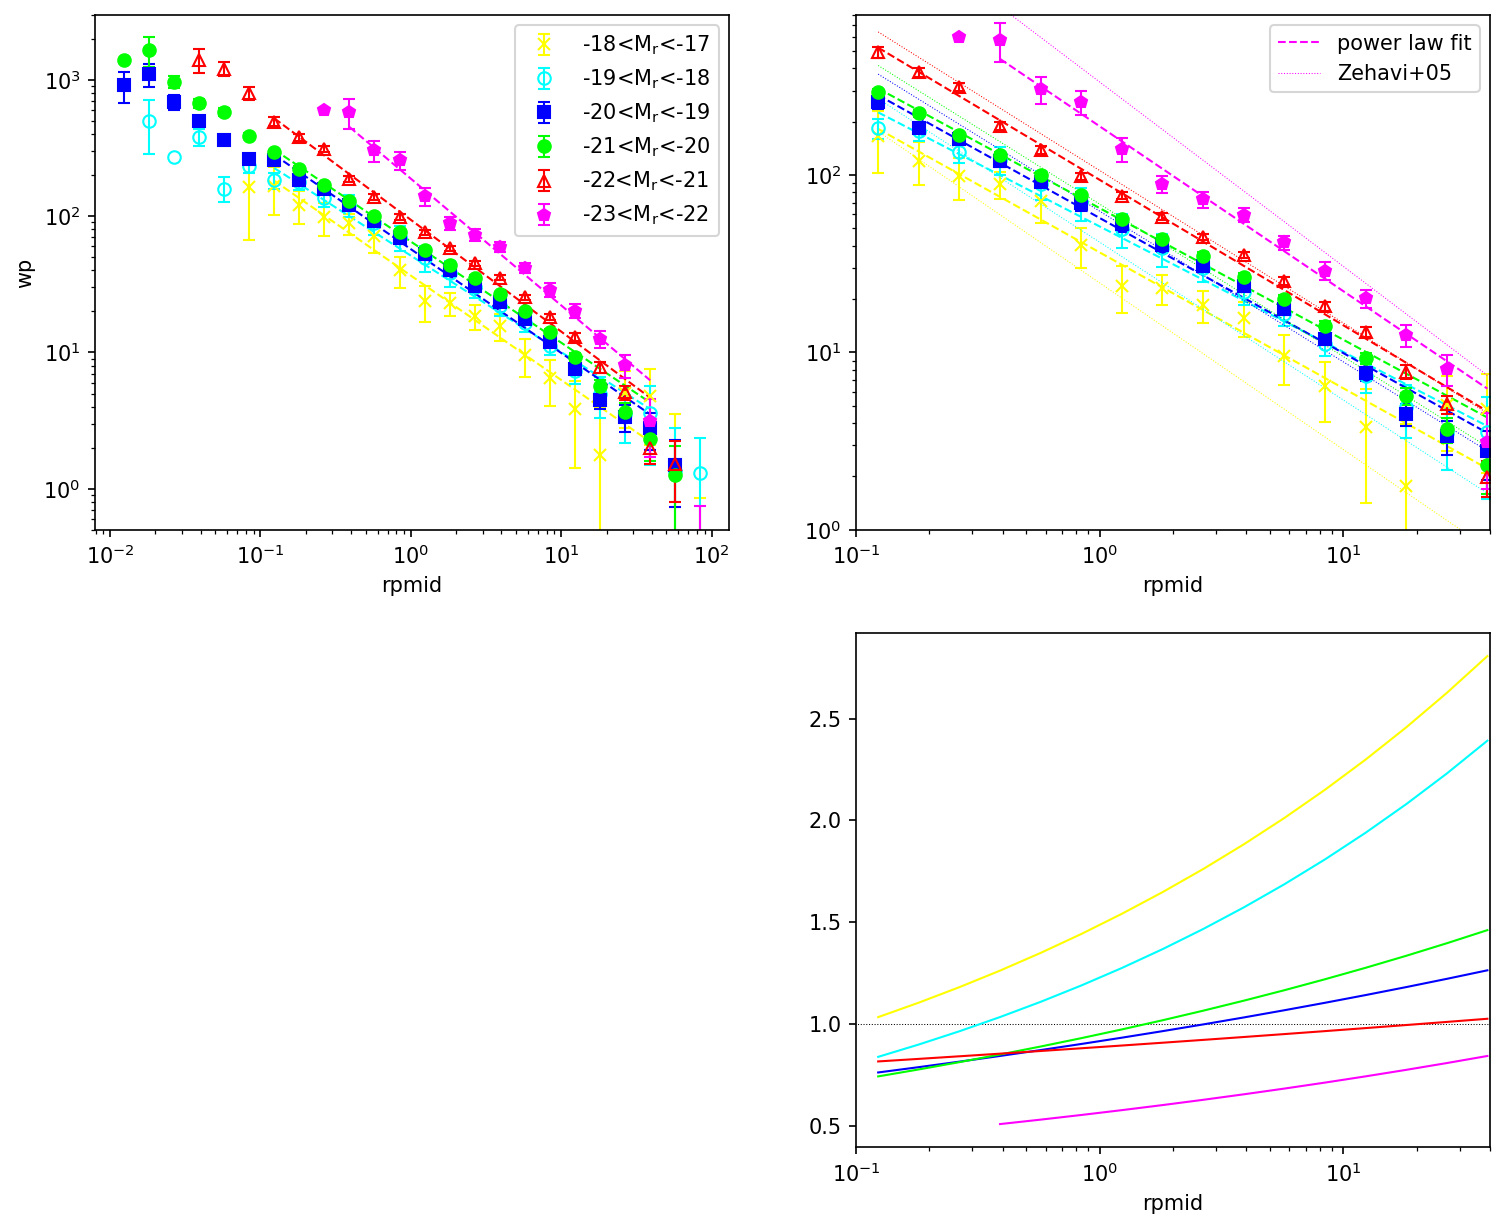

In [77]:
fig, ax = plt.subplots(figsize=(12,10),dpi=150)
ax1 = plt.subplot(221)
ax1.errorbar(wp_17_18[:,0], wp_17_18[:,2], yerr=wp_17_18[:,3], markersize=6, lw=0, elinewidth=1, capsize=3, ecolor='yellow', label='-18<$\mathrm{M_{r}}$<-17', marker='x', mfc='yellow', mec='yellow')
ax1.plot(wp_17_18_nonans[:,0][wp_17_18_nonanlim], power_law(wp_17_18_nonans[:,0][wp_17_18_nonanlim], power_17_18_lim), ls='--', lw=1, color='yellow')

ax1.errorbar(wp_18_19[:,0], wp_18_19[:,2], yerr=wp_18_19[:,3], markersize=6, lw=0, elinewidth=1, capsize=3, ecolor='cyan', label='-19<$\mathrm{M_{r}}$<-18', marker='o', mfc='None', mec='cyan')
ax1.plot(wp_18_19_nonans[:,0][wp_18_19_nonanlim], power_law(wp_18_19_nonans[:,0][wp_18_19_nonanlim], power_18_19_lim), ls='--', lw=1, color='cyan')

ax1.errorbar(wp_19_20[:,0], wp_19_20[:,2], yerr=wp_19_20[:,3], markersize=6, lw=0, elinewidth=1, capsize=3, ecolor='blue', label='-20<$\mathrm{M_{r}}$<-19', marker='s', mfc='blue', mec='blue')
ax1.plot(wp_19_20_nonans[:,0][wp_19_20_nonanlim], power_law(wp_19_20_nonans[:,0][wp_19_20_nonanlim], power_19_20_lim), ls='--', lw=1, color='blue')

ax1.errorbar(wp_20_21[:,0], wp_20_21[:,2], yerr=wp_20_21[:,3], markersize=6, lw=0, elinewidth=1, capsize=3, ecolor='lime', label='-21<$\mathrm{M_{r}}$<-20', marker='o', mfc='lime', mec='lime')
ax1.plot(wp_20_21_nonans[:,0][wp_20_21_nonanlim], power_law(wp_20_21_nonans[:,0][wp_20_21_nonanlim], power_20_21_lim), ls='--', lw=1, color='lime')

ax1.errorbar(wp_21_22[:,0], wp_21_22[:,2], yerr=wp_21_22[:,3], markersize=6, lw=0, elinewidth=1, capsize=3, ecolor='red', label='-22<$\mathrm{M_{r}}$<-21', marker='^', mfc='None', mec='red')
ax1.plot(wp_21_22_nonans[:,0][wp_21_22_nonanlim], power_law(wp_21_22_nonans[:,0][wp_21_22_nonanlim], power_21_22_lim), ls='--', lw=1, color='red')

ax1.errorbar(wp_22_23[:,0], wp_22_23[:,2], yerr=wp_22_23[:,3], markersize=6, lw=0, elinewidth=1, capsize=3, ecolor='magenta', label='-23<$\mathrm{M_{r}}$<-22', marker='p', mfc='magenta', mec='magenta')
ax1.plot(wp_22_23_nonans[:,0][wp_22_23_nonanlim], power_law(wp_22_23_nonans[:,0][wp_22_23_nonanlim], power_22_23_lim), ls='--', lw=1, color='magenta')

ax1.set_yscale('log')
plt.ylim(5*10**-1,3*10**3)
ax1.set_xscale('log')
plt.ylabel('wp')
plt.xlabel('rpmid')
plt.legend()

ax2 = plt.subplot(222)
ax2.errorbar(wp_17_18[:,0], wp_17_18[:,2], yerr=wp_17_18[:,3], markersize=6, lw=0, elinewidth=1, capsize=3, ecolor='yellow', marker='x', mfc='yellow', mec='yellow')
ax2.plot(wp_17_18_nonans[:,0][wp_17_18_nonanlim], power_law(wp_17_18_nonans[:,0][wp_17_18_nonanlim], power_17_18_lim), ls='--', lw=1, color='yellow')
ax2.plot(wp_17_18_nonans[:,0][wp_17_18_nonanlim], power_law(wp_17_18_nonans[:,0][wp_17_18_nonanlim], Z_power_17_18), ls=':', lw=0.5, color='yellow'),

ax2.errorbar(wp_18_19[:,0], wp_18_19[:,2], yerr=wp_18_19[:,3], markersize=6, lw=0, elinewidth=1, capsize=3, ecolor='cyan', marker='o', mfc='None', mec='cyan')
ax2.plot(wp_18_19_nonans[:,0][wp_18_19_nonanlim], power_law(wp_18_19_nonans[:,0][wp_18_19_nonanlim], power_18_19_lim), ls='--', lw=1, color='cyan')
ax2.plot(wp_18_19_nonans[:,0][wp_18_19_nonanlim], power_law(wp_18_19_nonans[:,0][wp_18_19_nonanlim], Z_power_18_19), ls=':', lw=0.5, color='cyan')

ax2.errorbar(wp_19_20[:,0], wp_19_20[:,2], yerr=wp_19_20[:,3], markersize=6, lw=0, elinewidth=1, capsize=3, ecolor='blue', marker='s', mfc='blue', mec='blue')
ax2.plot(wp_19_20_nonans[:,0][wp_19_20_nonanlim], power_law(wp_19_20_nonans[:,0][wp_19_20_nonanlim], power_19_20_lim), ls='--', lw=1, color='blue')
ax2.plot(wp_19_20_nonans[:,0][wp_19_20_nonanlim], power_law(wp_19_20_nonans[:,0][wp_19_20_nonanlim], Z_power_19_20), ls=':', lw=0.5, color='blue')

ax2.errorbar(wp_20_21[:,0], wp_20_21[:,2], yerr=wp_20_21[:,3], markersize=6, lw=0, elinewidth=1, capsize=3, ecolor='lime', marker='o', mfc='lime', mec='lime')
ax2.plot(wp_20_21_nonans[:,0][wp_20_21_nonanlim], power_law(wp_20_21_nonans[:,0][wp_20_21_nonanlim], power_20_21_lim), ls='--', lw=1, color='lime')
ax2.plot(wp_20_21_nonans[:,0][wp_20_21_nonanlim], power_law(wp_20_21_nonans[:,0][wp_20_21_nonanlim], Z_power_20_21), ls=':', lw=0.5, color='lime')

ax2.errorbar(wp_21_22[:,0], wp_21_22[:,2], yerr=wp_21_22[:,3], markersize=6, lw=0, elinewidth=1, capsize=3, ecolor='red', marker='^', mfc='None', mec='red')
ax2.plot(wp_21_22_nonans[:,0][wp_21_22_nonanlim], power_law(wp_21_22_nonans[:,0][wp_21_22_nonanlim], power_21_22_lim), ls='--', lw=1, color='red')
ax2.plot(wp_21_22_nonans[:,0][wp_21_22_nonanlim], power_law(wp_21_22_nonans[:,0][wp_21_22_nonanlim], Z_power_21_22), ls=':', lw=0.5, color='red')

ax2.errorbar(wp_22_23[:,0], wp_22_23[:,2], yerr=wp_22_23[:,3], markersize=6, lw=0, elinewidth=1, capsize=3, ecolor='magenta', marker='p', mfc='magenta', mec='magenta')
ax2.plot(wp_22_23_nonans[:,0][wp_22_23_nonanlim], power_law(wp_22_23_nonans[:,0][wp_22_23_nonanlim], power_22_23_lim), ls='--', lw=1, color='magenta', label='power law fit')
ax2.plot(wp_22_23_nonans[:,0][wp_22_23_nonanlim], power_law(wp_22_23_nonans[:,0][wp_22_23_nonanlim], Z_power_22_23), ls=':', lw=0.5, color='magenta', label='Zehavi+05')

ax2.set_yscale('log')
plt.ylim(1,800)
plt.xlim(0.1,40)
ax2.set_xscale('log')
plt.xlabel('rpmid')
plt.legend()

compare_17_18 = power_law(wp_17_18_nonans[:,0][wp_17_18_nonanlim], power_17_18_lim)/power_law(wp_17_18_nonans[:,0][wp_17_18_nonanlim], Z_power_17_18)
compare_18_19 = power_law(wp_18_19_nonans[:,0][wp_18_19_nonanlim], power_18_19_lim)/power_law(wp_18_19_nonans[:,0][wp_18_19_nonanlim], Z_power_18_19)
compare_19_20 = power_law(wp_19_20_nonans[:,0][wp_19_20_nonanlim], power_19_20_lim)/power_law(wp_19_20_nonans[:,0][wp_19_20_nonanlim], Z_power_19_20)
compare_20_21 = power_law(wp_20_21_nonans[:,0][wp_20_21_nonanlim], power_20_21_lim)/power_law(wp_20_21_nonans[:,0][wp_20_21_nonanlim], Z_power_20_21)
compare_21_22 = power_law(wp_21_22_nonans[:,0][wp_21_22_nonanlim], power_21_22_lim)/power_law(wp_21_22_nonans[:,0][wp_21_22_nonanlim], Z_power_21_22)
compare_22_23 = power_law(wp_22_23_nonans[:,0][wp_22_23_nonanlim], power_22_23_lim)/power_law(wp_22_23_nonans[:,0][wp_22_23_nonanlim], Z_power_22_23)


ax4 = plt.subplot(224)
ax4.plot([0,40],[1,1], ls=':', color='k', lw=0.5)
ax4.plot(wp_17_18_nonans[:,0][wp_17_18_nonanlim], compare_17_18, ls='-', lw=1, color='yellow')
ax4.plot(wp_18_19_nonans[:,0][wp_18_19_nonanlim], compare_18_19, ls='-', lw=1, color='cyan')
ax4.plot(wp_19_20_nonans[:,0][wp_19_20_nonanlim], compare_19_20, ls='-', lw=1, color='blue')
ax4.plot(wp_20_21_nonans[:,0][wp_20_21_nonanlim], compare_20_21, ls='-', lw=1, color='lime')
ax4.plot(wp_21_22_nonans[:,0][wp_21_22_nonanlim], compare_21_22, ls='-', lw=1, color='red')
ax4.plot(wp_22_23_nonans[:,0][wp_22_23_nonanlim], compare_22_23, ls='-', lw=1, color='magenta')

#ax4.set_yscale('log')
#plt.ylim(1,800)
plt.xlim(0.1,40)
ax4.set_xscale('log')
plt.xlabel('rpmid')

plt.savefig('../figures/week6-7/sv3_clustering_magbins.png')

In [40]:
ax4.plot(wp_17_18_nonans[:,0][wp_17_18_nonanlim], power_law(wp_17_18_nonans[:,0][wp_17_18_nonanlim], power_17_18_lim), ls='--', lw=1, color='yellow')
ax4.plot(wp_17_18_nonans[:,0][wp_17_18_nonanlim], power_law(wp_17_18_nonans[:,0][wp_17_18_nonanlim], Z_power_17_18), ls='-', lw=0.5, color='yellow'),

ax4.plot(wp_18_19_nonans[:,0][wp_18_19_nonanlim], power_law(wp_18_19_nonans[:,0][wp_18_19_nonanlim], power_18_19_lim), ls='--', lw=1, color='cyan')
ax4.plot(wp_18_19_nonans[:,0][wp_18_19_nonanlim], power_law(wp_18_19_nonans[:,0][wp_18_19_nonanlim], Z_power_18_19), ls='-', lw=0.5, color='cyan')

ax4.plot(wp_19_20_nonans[:,0][wp_19_20_nonanlim], power_law(wp_19_20_nonans[:,0][wp_19_20_nonanlim], power_19_20_lim), ls='--', lw=1, color='blue')
ax4.plot(wp_19_20_nonans[:,0][wp_19_20_nonanlim], power_law(wp_19_20_nonans[:,0][wp_19_20_nonanlim], Z_power_19_20), ls='-', lw=0.5, color='blue')

ax4.plot(wp_20_21_nonans[:,0][wp_20_21_nonanlim], power_law(wp_20_21_nonans[:,0][wp_20_21_nonanlim], power_20_21_lim), ls='--', lw=1, color='lime')
ax4.plot(wp_20_21_nonans[:,0][wp_20_21_nonanlim], power_law(wp_20_21_nonans[:,0][wp_20_21_nonanlim], Z_power_20_21), ls='-', lw=0.5, color='lime')

ax4.plot(wp_21_22_nonans[:,0][wp_21_22_nonanlim], power_law(wp_21_22_nonans[:,0][wp_21_22_nonanlim], power_21_22_lim), ls='--', lw=1, color='red')
ax4.plot(wp_21_22_nonans[:,0][wp_21_22_nonanlim], power_law(wp_21_22_nonans[:,0][wp_21_22_nonanlim], Z_power_21_22), ls='-', lw=0.5, color='red')

ax4.plot(wp_22_23_nonans[:,0][wp_22_23_nonanlim], power_law(wp_22_23_nonans[:,0][wp_22_23_nonanlim], power_22_23_lim), ls='--', lw=1, color='magenta')
ax4.plot(wp_22_23_nonans[:,0][wp_22_23_nonanlim], power_law(wp_22_23_nonans[:,0][wp_22_23_nonanlim], Z_power_22_23), ls='-', lw=0.5, color='magenta', label='Zehavi+05'), power_18_19_lim), ls='--', lw=1, color='cyan')



1.0081769737043482
0.0009083773300357667


In [43]:
print(gamma(0.5))

1.7724538509055159
